In [1]:
from IPython.display import HTML
from IPython.display import Image 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Assignment 4 - Part 2 | Tweet Disaster
David Thor MSDS 422 - Practical Machine Learning


# Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats
import matplotlib.gridspec as gridspec
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import glob
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from keras.models import load_model, save_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
#from plot_keras_history import show_history, plot_history
#import scikitplot as skplt
from IPython.utils import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import save, load
from pickleshare import PickleShareDB
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
%matplotlib inline

Using TensorFlow backend.


In [3]:
os.getcwd()

'/Users/dthor/Desktop/Assignment 4/Disaster'

# Part 0 - Importing Data



In [4]:
##Importing Data
trainDat = pd.read_csv('train.csv')
testDat =  pd.read_csv('test.csv')

In [5]:
trainDat.shape
testDat.shape
trainDat.info()

(7613, 5)

(3263, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
# checking variables to make sure label is the y variable
set(trainDat.columns).difference(set(testDat.columns))

{'target'}

# Feature Engineer
- I decided to concatenate the location, keywords and text together because I felt the keywodr and location were also important features to include in the text.
- The method below combines the 3 features/text into a new colum called 'combined'

In [7]:
# Method to feature engineer
def combine_features(df):
    df.fillna('', inplace=True)
    cols = ['keyword', 'location', 'text']
    df['combined'] = df[cols].apply(lambda row: ''.join(\
                                            row.values.astype(str)), axis=1)
    #trainDat.drop('allText', axis=1, inplace=True)
    #trainDat['combined'] = trainDat['combined'].map(lambda x: x.lstrip(''))
    return df

In [8]:
trainDat = combine_features(trainDat)
trainDat

,id,keyword,location,text,target,combined
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,,,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...


In [10]:
# Converting the dataframe columns into list
tweets = trainDat.combined.tolist()
labels = trainDat.target.tolist()
len(tweets)
len(labels)

7613

7613

# Decision Reasoning
- I decided to use 80 as max review length because I feel like tweets are usually shorter than this based on my experience with Twitter.
- I also split the training/validation to approx 80/20 with about 100 words for the final exam.
- I also think the max words of 10000 was sufficient (similar to the sync session with movie reviews)
- For two of the models below, I also used the pre-trained glove.6B.100d.txt similar to the sync session movie reviews example
- I also followed the same tokenization/padding as the sync session example. As the Tokenizer already removes punctuation and left padding as default seemed reasonable.
- I will explain model differences and additional decision analysis later.

In [11]:
# Some hyperparams.
maxLen = 80     # maximum review length
trainDatNbr = 6000    # number of reviews that will be used for training
valDatNbr = 1513      # reviews for validation
testDatNbr = 100     # data for final model evaluation
maxWords = 10000    # max number of words ot use

In [12]:
tokenizer = Tokenizer(num_words=maxWords)  # split into words, no more tha 10k
# The tokenizer will by default remove punctuation

tokenizer.fit_on_texts(tweets) # reviews is a list of review texts
sequences = tokenizer.texts_to_sequences(tweets)

paddedSeqs = pad_sequences(sequences,maxLen)  # A np array
labels = np.asarray(labels)   # Another np array

In [13]:
# This will be neededin a subsequent step about the vectors
wordIndx=tokenizer.word_index
type(wordIndx)

dict

In [14]:
print(f'number of padded sequences: {len(paddedSeqs)}')

number of padded sequences: 7613


# Splitting Reviews Into Train, Validate, Test

In [15]:
# Random sort of labels and reviews

np.random.seed(55)

Indx = np.arange(len(paddedSeqs))

np.random.shuffle(Indx)

labels=labels[Indx]

paddedSeqs=paddedSeqs[Indx]

In [16]:
# Splitting data

XTrain = paddedSeqs[:trainDatNbr]   # training data
yTrain = labels[:trainDatNbr]       # training labels

XVal = paddedSeqs[trainDatNbr:trainDatNbr+valDatNbr]
yVal = labels[trainDatNbr:trainDatNbr+valDatNbr]

XTest = paddedSeqs[trainDatNbr+valDatNbr:trainDatNbr+valDatNbr+
                  testDatNbr]
yTest = labels[trainDatNbr+valDatNbr:trainDatNbr+valDatNbr+
                  testDatNbr]

In [17]:
# checks on shapes
XTrain.shape
yTrain.shape
XVal.shape
yVal.shape
XTest.shape
yTest.shape

(6000, 80)

(6000,)

(1513, 80)

(1513,)

(100, 80)

(100,)

In [18]:
# Using the same pre-trained100 dimensions as sync session movie reivews
GloVeFil='glove.6B.100d.txt'  # vector file

emIndx=dict()

with open(GloVeFil) as inFile:
    emFil=inFile.readlines()
cnt = 0
for line in emFil:      # reading line by line
    vals = line.split()
    word = vals[0]   # word is first value in each line
    coefs = np.asarray(vals[1:],dtype='float32')# rest of line read in nparray
    emIndx[word]=coefs



In [19]:
print(f'number of vectors {len(emIndx)}')

number of vectors 400000


In [21]:
maxWords=10000
emDim=100 # GloVe dimension
emMat=np.zeros((maxWords,emDim))   # start with all zeros

for word, i in wordIndx.items():
    if i < maxWords:
        emVec = emIndx.get(word)# default is None when word is not in index
        if emVec is not None:
            emMat[i]=emVec

In [22]:
# Let's take a look at the embedding matrix

type(emMat)
emMat.shape

numpy.ndarray

(10000, 100)

In [28]:
emMat.shape

(10000, 100)

## Baseline (Model 0)
- This baseline model is simliar to the baseline model in the sync session 7.
- The only diffderent is that this model 0 will not use the pre-trained word embeddings.
- The neural network will also not be Bidirectional in this model. Other models will be bidirectional as I felt it's important for the model to account for the keywords/location from the beginning segments of the reviews.
- The epics of 10 and batch size 32 will also remain constant
- This baseline model yield an accuracy of 67% against the final exam data. 

In [34]:
# Assist with removing the TensorFlow warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [35]:
model = Sequential()
model.add(Embedding(maxWords,emDim,input_length=maxLen))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 100)           1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                512064    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,512,129
Trainable params: 1,512,129
Non-trainable params: 0
_________________________________________________________________


In [37]:
#Basic Compile. Bingary_crossentropy because this is a binary classification
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [38]:
# I also dicided to stick with the defaults of 10 epics, and batch size of 32.
# I felt these were good basic hyperparameters 
##  and will remain constant in this project.
history=model.fit(XTrain, yTrain,
        epochs=10,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0)
model.save_weights('assign-4-selftrained-test-1.h5')

In [50]:
## This code shows the accuracy of the baseline model
accuracy_baseline_final_exam = accuracy_score(yTest,(\
                                model.predict(XTest) > 0.5).astype("int32"))
print (f' Accuracy: ', \
       accuracy_baseline_final_exam)

 Accuracy:  0.67


## Model 1
- This first model uses the pre-trained word embeddings. (notice the non-trainable milllion params).
- All other variables/hyper parameters are the same from the baseline Model 0.
- I wanted to see the different in accuracy using pre-trained versus self-trained weights.
- This model yeild an accuracy of 76%. Better than the previous which is not too surprising considering the pre-trained is probably good/well-known for all-around NLP.

In [54]:
model1 = Sequential()
model1.add(Embedding(maxWords,emDim,input_length=maxLen))
model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

In [56]:
# This part indicates that the embedding layer is already trained, 
##  and thus should not be trained.

# here's where the embedding matrix is added
model1.layers[0].set_weights([emMat])
model1.layers[0].trainable=False   # Don't train this layer

In [87]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 80, 100)           1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                512064    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 1,512,129
Trainable params: 512,129
Non-trainable params: 1,000,000
_________________________________________________________________


In [57]:
model1.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [58]:
history=model1.fit(XTrain, yTrain,
        epochs=10,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0)
model.save_weights('assign-4-selftrained-test-1.h5')

In [59]:
## This code shows the accuracy of model 1
accuracy_model1_final_exam = accuracy_score(yTest,\
                            (model1.predict(XTest) > 0.5).astype("int32"))
print (f' Accuracy: ', \
       accuracy_model1_final_exam)

 Accuracy:  0.76


## Model 2
- The big difference in this model is the bidirectional LSTM used in the RNN. Since I concatenated keywords/location to the tweet text, the model needed a way to account for those important keywords in the begnning of the RNN.
- This second model does not use the pre-trained word embeddings.
- All other variables/hyper parameters are the same.
- This model yeild an accuracy of 69%. Surprised me a little as I thought this would further improve the score from Models 0 and 1.

In [64]:
# The big difference here is the bidirectional LTSM.
model2 = Sequential()
model2.add(Embedding(maxWords,emDim,input_length=maxLen))
model2.add(Bidirectional(LSTM(64)))
model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

In [65]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 80, 100)           1000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,092,801
Trainable params: 1,092,801
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [45]:
history=model2.fit(XTrain, yTrain,
        epochs=10,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0)
model.save_weights('assign-4-selftrained-test-1.h5')

In [53]:
## This code shows the accuracy of the model 2.
accuracy_model2_final_exam = accuracy_score(\
                        yTest,(model2.predict(XTest) > 0.5).astype("int32"))
print (f' Accuracy: ', \
       accuracy_model2_final_exam)

 Accuracy:  0.69


## Model 3
- This last model here is an RNN model that uses pre-trained word embeddings as well as the Bidirectional LSTM layer. There will be 1 million non-trainable params. My huntch is that this model would yield the best accuracy.
- All other variables/hyper parameters are the same.
- This model yeild an accuracy of 80%. As expected, this model did perform better than the previous ones. However, this did take the longest to build.

In [67]:
model3 = Sequential()
model3.add(Embedding(maxWords,emDim,input_length=maxLen))
model3.add(Bidirectional(LSTM(64)))
model3.add(Flatten())
model3.add(Dense(64,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))

In [69]:
# This part indicates that the embedding layer is already trained, 
##  and thus should not be trained.
model3.layers[0].set_weights([emMat])#where the embedding matrix is added
model3.layers[0].trainable=False# Don't train this layer

In [88]:
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 80, 100)           1000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 1,092,801
Trainable params: 92,801
Non-trainable params: 1,000,000
_________________________________________________________________


In [70]:
model3.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [71]:
history=model3.fit(XTrain, yTrain,
        epochs=10,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0)
model.save_weights('assign-4-selftrained-test-1.h5')

In [72]:
## This code shows the accuracy of the final model 3 
accuracy_model3_final_exam = \
accuracy_score(yTest,(model3.predict(XTest) > 0.5).astype("int32"))
print (f' Accuracy: ', \
       accuracy_model3_final_exam)

 Accuracy:  0.8


## Visuals for Model 3 (best)
- Out of curiousity, I wanted to see how the model progresed.
- I noticed both the training and validation accuracy continues to increase.
- I would think that if I increased the epics, this would improve my model
- However, due to time constrants and long training times, I figured 80% was good enough

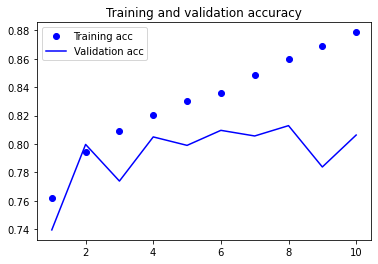

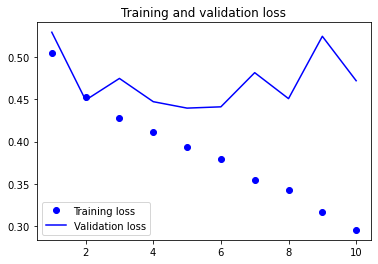

In [73]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

In [74]:
# Gradual increase in training and validation accuracy overtime.
resDF=pd.DataFrame(history.history)
print(resDF[['acc','val_acc','loss','val_loss']])

        acc   val_acc      loss  val_loss
0  0.762000  0.739590  0.505039  0.529143
1  0.794500  0.799736  0.452810  0.448977
2  0.809500  0.773959  0.427790  0.474592
3  0.820333  0.805023  0.411473  0.447126
4  0.830333  0.799075  0.393527  0.439522
5  0.836000  0.809650  0.379422  0.441046
6  0.848333  0.805684  0.355137  0.481399
7  0.859667  0.812954  0.342377  0.450727
8  0.869000  0.783873  0.316881  0.524362
9  0.878667  0.806345  0.295653  0.471885


# RNN Results/Summary
- Overall, the model improves as I continue to tune/tweak the model.
- With additional time and resources, this model could potentially yield upwards of 90%.
- Other parameters I think would've yield the best results were the number of epics and/or the layers.
- Below is a summary of the four different models and the specific parameters I tested with in my experiment.

In [91]:
from tabulate import tabulate

model_results = [
    ["Baseline", "No", "No", "<10 mins", "67%"],
    ["Model 1", "Yes", "No", "<10 mins", "76%"],
    ["Model 2", "No", "Yes", ">10 mins","69%"],
    ["Model 3", "Yes", "Yes", ">10 mins", "80%"],
]
 
# create header
model_head = ["Model", "Pre-trained Words?", "Bidirectional LSTM?",\
              "Processing time?", "Final Test Accuracy"]
 
# display table
#print(tabulate(model_results, headers=model_head, tablefmt="html"))

<table align=left>
<thead>
<tr><th>Model   </th><th>Pre-trained Words?  </th><th>Bidirectional LSTM?  </th><th>Processing time?  </th><th>Final Test Accuracy  </th></tr>
</thead>
<tbody>
<tr><td>Baseline</td><td>No                  </td><td>No                   </td><td>&lt;10 mins          </td><td>67%                  </td></tr>
<tr><td>Model 1 </td><td>Yes                 </td><td>No                   </td><td>&lt;10 mins          </td><td>76%                  </td></tr>
<tr><td>Model 2 </td><td>No                  </td><td>Yes                  </td><td>&gt;10 mins          </td><td>69%                  </td></tr>
<tr><td>Model 3 </td><td>Yes                 </td><td>Yes                  </td><td>&gt;10 mins          </td><td>80%                  </td></tr>
</tbody>
</table>

## Implement/Submission
- Model 3 wins!

In [77]:
testDat = pd.read_csv('test.csv')

In [78]:
# Feature Engineer. This step combines the keyword, location and tweet text.
testDat = combine_features(testDat)

In [79]:
# Converts this to list for tokenization processing
final_tweets = testDat.combined.tolist()

In [80]:
#tokenizes
final_tweets_seq = tokenizer.texts_to_sequences(final_tweets)

In [81]:
#add paddings to front of sequences/sentences
final_tweets_paddedSeqs = pad_sequences(final_tweets_seq,maxLen)

In [82]:
#Prediction
y_pred = model3.predict(final_tweets_paddedSeqs)

In [83]:
y_pred

array([[0.68836194],
       [0.6748655 ],
       [0.9062563 ],
       ...,
       [0.96952057],
       [0.74593264],
       [0.8359334 ]], dtype=float32)

In [85]:
submission = pd.read_csv("sample_submission.csv")
submission["target"] = y_pred
#If the ratio is > 0.5, then it is likely a disaster!
submission["target"] = submission["target"]\
.apply(lambda x : 0 if x<=.5 else 1)

In [86]:
submission.to_csv("disaster_submission.csv", index=False)